In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from skimage.feature import local_binary_pattern


In [ ]:
img_height, img_width = 224, 224

# Dataset directory
dataset_dir = './Chest_X_Ray_Dataset/'  

class_labels = ['TURBERCULOSIS', 'NORMAL', 'COVID19', 'PNEUMONIA']

def load_and_preprocess_data(dataset_dir):
    images = []
    labels = []

    for label in class_labels:
        label_dir = os.path.join(dataset_dir, label)
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            # Load the image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

            
            img = cv2.GaussianBlur(img, (3, 3), 0)

            # Apply Canny Edge Detection
            edges = cv2.Canny(img, 30, 65)

            img_resized = cv2.resize(edges, (img_height, img_width))
            # img_resized = cv2.resize(img, (img_height, img_width))

        
            images.append(img_resized)
            labels.append(class_labels.index(label))

    images = np.array(images)
    labels = np.array(labels)

    # Normalize the images
    images = images.astype('float32') / 255.0

    # Reshape to (num_samples, height, width, 1) for CNN input
    images = np.expand_dims(images, axis=-1)

    return images, labels

# Load dataset
images, labels = load_and_preprocess_data(dataset_dir)


In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

In [4]:
def create_SIFT_features(data):
    Feature_data = np.zeros((len(data),224,224,3))

    for i in range(len(data)):
        img = data[i]
        image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(image8bit,None)

        img = cv2.drawKeypoints(image=image8bit, outImage=img, keypoints = kp, flags = 4, color = (255, 0, 0))
        Feature_data[i] = img/255.0

        
    return Feature_data 

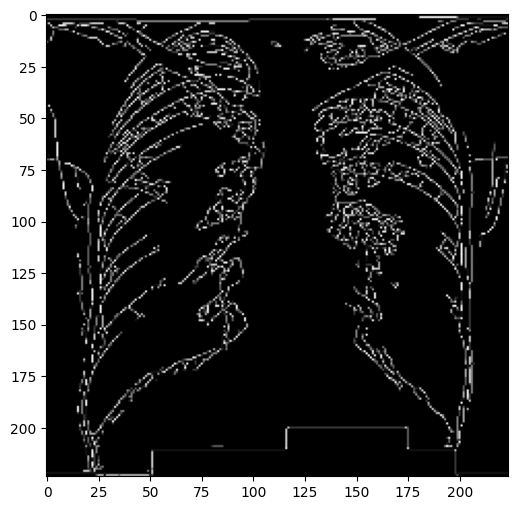

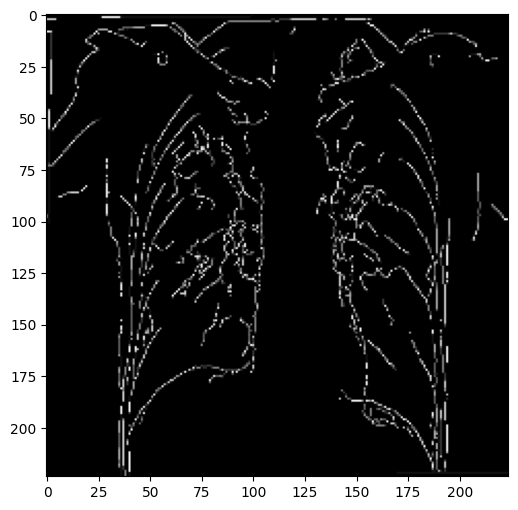

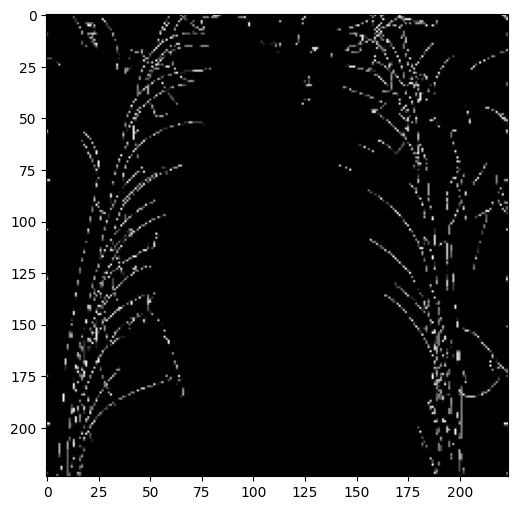

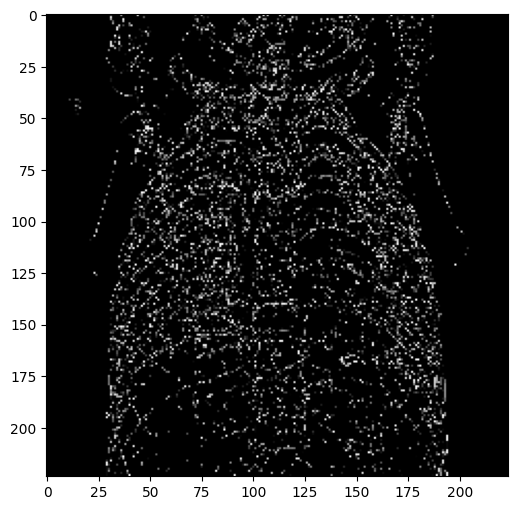

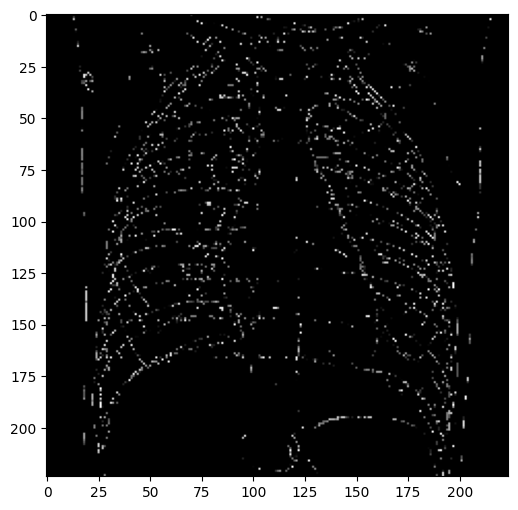

In [6]:
import random
for i in range(5):
    plt.figure(figsize=(10,6))
    plt.imshow(random.choice(X_train), cmap='gray')
    plt.show()

In [7]:
X_train.shape

(5705, 224, 224, 1)

In [8]:
y_train.shape

(5705,)

In [9]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=4)

In [10]:
y_train.shape

(5705, 4)

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(224,224,1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
    
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [13]:
model.compile(optimizer= tf.keras.optimizers.Adam(1e-5), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=32)

Epoch 1/15
179/179 [==============================] - 24s 84ms/step - loss: 0.8685 - accuracy: 0.6538 - val_loss: 0.6396 - val_accuracy: 0.7237
Epoch 2/15
179/179 [==============================] - 15s 82ms/step - loss: 0.5196 - accuracy: 0.8014 - val_loss: 0.4801 - val_accuracy: 0.8331
Epoch 3/15
179/179 [==============================] - 15s 83ms/step - loss: 0.3994 - accuracy: 0.8566 - val_loss: 0.4370 - val_accuracy: 0.8205
Epoch 4/15
179/179 [==============================] - 15s 83ms/step - loss: 0.3576 - accuracy: 0.8747 - val_loss: 0.3871 - val_accuracy: 0.8640
Epoch 5/15
179/179 [==============================] - 15s 83ms/step - loss: 0.3261 - accuracy: 0.8845 - val_loss: 0.3734 - val_accuracy: 0.8597
Epoch 6/15
179/179 [==============================] - 15s 83ms/step - loss: 0.3038 - accuracy: 0.8938 - val_loss: 0.3456 - val_accuracy: 0.8766
Epoch 7/15
179/179 [==============================] - 15s 83ms/step - loss: 0.2819 - accuracy: 0.9001 - val_loss: 0.3738 - val_accuracy:

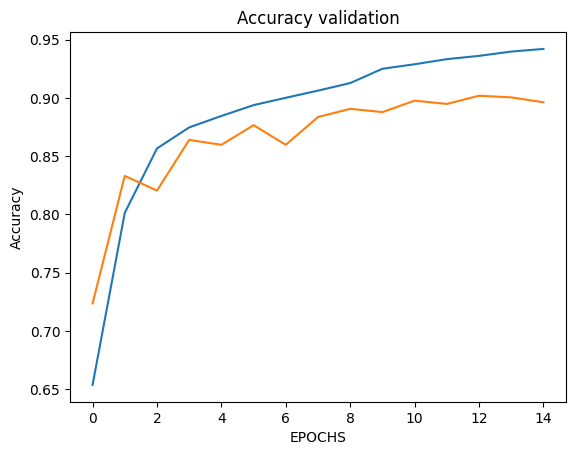

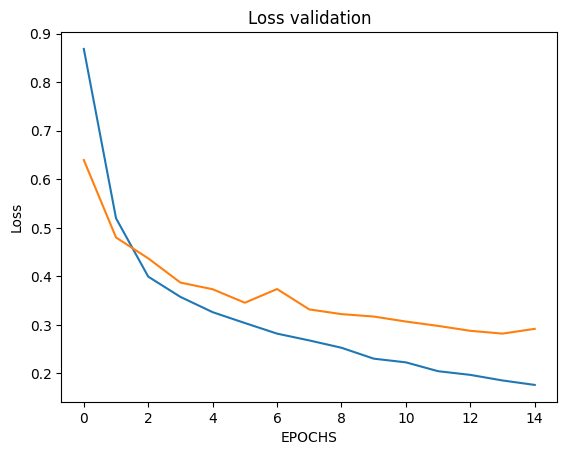

In [15]:
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_accuracy')
plt.xlabel("EPOCHS")
plt.ylabel("Accuracy")
plt.title("Accuracy validation")
plt.show()


plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.xlabel("EPOCHS")
plt.ylabel("Loss")
plt.title("Loss validation")
plt.show()

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)

23/23 [==============================] - 1s 33ms/step - loss: 0.2549 - accuracy: 0.9048


In [17]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

23/23 [==============================] - 1s 19ms/step


In [18]:
for i in range(10):
    pred = class_labels[y_pred_classes[i]]
    actual = class_labels[np.argmax(y_test[i])]
    print(f"No {i}, Prediction : {pred} - Actual : {actual}")

No 0, Prediction : NORMAL - Actual : NORMAL
No 1, Prediction : PNEUMONIA - Actual : PNEUMONIA
No 2, Prediction : NORMAL - Actual : NORMAL
No 3, Prediction : NORMAL - Actual : NORMAL
No 4, Prediction : TURBERCULOSIS - Actual : TURBERCULOSIS
No 5, Prediction : TURBERCULOSIS - Actual : TURBERCULOSIS
No 6, Prediction : COVID19 - Actual : COVID19
No 7, Prediction : COVID19 - Actual : COVID19
No 8, Prediction : PNEUMONIA - Actual : PNEUMONIA
No 9, Prediction : PNEUMONIA - Actual : PNEUMONIA
